# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
from tqdm import notebook
import re
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score
import time

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\кирилл\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path1_data = '/datasets/toxic_comments.csv'
path2_data = 'toxic_comments.csv'

if os.path.exists(path1_data):
    data = pd.read_csv(path1_data)
elif os.path.exists(path2_data):
    data = pd.read_csv(path2_data)
else : 
    print('Something is Wrong')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data = data.drop('Unnamed: 0', axis=1)
data = data.dropna()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
display(data['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64

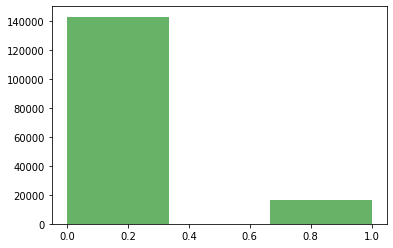

In [8]:
h = data['toxic'].hist(bins=3, alpha=0.6, color='Green', grid=False)
fig = h.get_figure()

In [9]:
m = WordNetLemmatizer()
def lemmatize(text):
    
    #lemm_list = m.lemmatize(text)
    #lemm_text = " ".join(lemm_list)  
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([m.lemmatize(w) for w in word_list])
    return lemm_text

def clear_text(text):
    text = re.sub(r'[^a-zA-Z]',' ', text)
    text = " ".join(text.split())
    return text

data['text'] = data['text'].apply(clear_text)
data['lemmatize'] = data['text'].apply(lemmatize)

In [10]:
data = data.drop(['text'], axis = 1)
data_train, data_valid = train_test_split(data , test_size = 0.2, random_state = 12345)
data_train, data_test = train_test_split(data , test_size = 0.25, random_state = 12345)
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(119469, 2)
(31859, 2)
(39823, 2)


In [11]:
features_train_full = data_train.drop('toxic', axis=1)
target_train_full = data_train['toxic']

In [12]:
#downsemple
tox_messages = data_train[data_train["toxic"] == 1]
untox_messages  = data_train[data_train["toxic"] == 0]
print(tox_messages.shape)
print(untox_messages.shape)

ham_downsample = resample(untox_messages,
             replace=True,
             n_samples=len(tox_messages),
             random_state=42)

print(ham_downsample.shape)

data_train_downsampled = pd.concat([ham_downsample, tox_messages])

print(data_train_downsampled["toxic"].value_counts())

(12142, 2)
(107327, 2)
(12142, 2)
0    12142
1    12142
Name: toxic, dtype: int64


In [13]:
features_train = data_train_downsampled.drop('toxic', axis=1)
target_train = data_train_downsampled['toxic']

features_valid = data_valid.drop('toxic', axis=1)
target_valid = data_valid['toxic']

features_test = data_test.drop('toxic', axis=1)
target_test = data_test['toxic']

In [14]:
print(features_train.shape)
print(target_train.shape)


print(features_valid.shape)
print(target_valid.shape)


print(features_test.shape)
print(target_test.shape)

(24284, 1)
(24284,)
(31859, 1)
(31859,)
(39823, 1)
(39823,)


In [15]:
corpus_train = features_train['lemmatize'].values
corpus_valid = features_valid['lemmatize'].values
corpus_test = features_test['lemmatize'].values
corpus_train_full = features_train_full['lemmatize'].values

In [16]:
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

In [17]:
features_train_full = count_tf_idf.fit_transform(corpus_train_full)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)
tf_idf_train = count_tf_idf.transform(corpus_train)

In [18]:
print(tf_idf_train.shape)
print(target_train.shape)
print(tf_idf_valid.shape)
print(target_valid.shape)
print(tf_idf_test.shape)
print(target_test.shape)

(24284, 137912)
(24284,)
(31859, 137912)
(31859,)
(39823, 137912)
(39823,)


In [19]:
kf = KFold(n_splits=3, shuffle=False)

- Импортировал библиотеки
- Открыд файл
- Ознакомился с жанными 
- Сделал леммитизацию
- Сбалансировал классы
- Расчитал TF-IDF

## Обучение

In [21]:
param = {"C":np.logspace(0.1 , 10, 7)}
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced'),
                      param,
                      cv=kf,
                      scoring='f1',
                      n_jobs=-1,
                      verbose=10
                      )

grid_lr.fit(features_train_full, target_train_full) #(upsample score = 0.65  , downsample score = 0.55 , balanced score = 74.5)
print(grid_lr.best_score_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START C=1.2589254117941673........................................
[CV 1/3; 1/7] END .........C=1.2589254117941673;, score=0.746 total time=  50.2s
[CV 2/3; 1/7] START C=1.2589254117941673........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 1/7] END .........C=1.2589254117941673;, score=0.746 total time=  49.8s
[CV 3/3; 1/7] START C=1.2589254117941673........................................
[CV 3/3; 1/7] END .........C=1.2589254117941673;, score=0.749 total time=  48.6s
[CV 1/3; 2/7] START C=56.23413251903494.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 2/7] END ..........C=56.23413251903494;, score=0.741 total time=  50.7s
[CV 2/3; 2/7] START C=56.23413251903494.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 2/7] END ..........C=56.23413251903494;, score=0.750 total time=  50.2s
[CV 3/3; 2/7] START C=56.23413251903494.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 2/7] END ..........C=56.23413251903494;, score=0.753 total time=  51.2s
[CV 1/3; 3/7] START C=2511.886431509582.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 3/7] END ..........C=2511.886431509582;, score=0.721 total time=  48.2s
[CV 2/3; 3/7] START C=2511.886431509582.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 3/7] END ..........C=2511.886431509582;, score=0.721 total time=  51.6s
[CV 3/3; 3/7] START C=2511.886431509582.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 3/7] END ..........C=2511.886431509582;, score=0.731 total time=  49.7s
[CV 1/3; 4/7] START C=112201.84543019629........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 4/7] END .........C=112201.84543019629;, score=0.707 total time=  48.6s
[CV 2/3; 4/7] START C=112201.84543019629........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 4/7] END .........C=112201.84543019629;, score=0.719 total time=  50.0s
[CV 3/3; 4/7] START C=112201.84543019629........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 4/7] END .........C=112201.84543019629;, score=0.721 total time=  47.7s
[CV 1/3; 5/7] START C=5011872.336272725.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 5/7] END ..........C=5011872.336272725;, score=0.713 total time=  48.7s
[CV 2/3; 5/7] START C=5011872.336272725.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 5/7] END ..........C=5011872.336272725;, score=0.714 total time=  49.6s
[CV 3/3; 5/7] START C=5011872.336272725.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 5/7] END ..........C=5011872.336272725;, score=0.717 total time=  52.2s
[CV 1/3; 6/7] START C=223872113.8568338.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 6/7] END ..........C=223872113.8568338;, score=0.713 total time=  48.8s
[CV 2/3; 6/7] START C=223872113.8568338.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 6/7] END ..........C=223872113.8568338;, score=0.715 total time=  50.5s
[CV 3/3; 6/7] START C=223872113.8568338.........................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 6/7] END ..........C=223872113.8568338;, score=0.723 total time=  49.7s
[CV 1/3; 7/7] START C=10000000000.0.............................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 7/7] END ..............C=10000000000.0;, score=0.715 total time=  49.9s
[CV 2/3; 7/7] START C=10000000000.0.............................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 7/7] END ..............C=10000000000.0;, score=0.717 total time=  49.0s
[CV 3/3; 7/7] START C=10000000000.0.............................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 7/7] END ..............C=10000000000.0;, score=0.723 total time=  48.7s
0.748103598474827


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
start = time.time()
predictions = grid_lr.best_estimator_.predict(tf_idf_train)
end = time.time()
pred_lr_time = end-start 

In [24]:
param = {'max_depth': np.arange(2, 15),
         'n_estimators': np.arange(10, 51, 10)
        }

grid_rfc = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                       param,
                       cv=kf,
                       scoring='f1',
                       n_jobs=-1,
                       verbose=10
                       )
grid_rfc.fit(features_train_full, target_train_full)  # (upsemple score = 0.27 , balanced score = 0.36)
print(grid_rfc.best_score_)

Fitting 3 folds for each of 65 candidates, totalling 195 fits
[CV 1/3; 1/65] START max_depth=2, n_estimators=10...............................
[CV 1/3; 1/65] END max_depth=2, n_estimators=10;, score=0.221 total time=   0.7s
[CV 2/3; 1/65] START max_depth=2, n_estimators=10...............................
[CV 2/3; 1/65] END max_depth=2, n_estimators=10;, score=0.220 total time=   0.6s
[CV 3/3; 1/65] START max_depth=2, n_estimators=10...............................
[CV 3/3; 1/65] END max_depth=2, n_estimators=10;, score=0.237 total time=   0.6s
[CV 1/3; 2/65] START max_depth=2, n_estimators=20...............................
[CV 1/3; 2/65] END max_depth=2, n_estimators=20;, score=0.241 total time=   1.2s
[CV 2/3; 2/65] START max_depth=2, n_estimators=20...............................
[CV 2/3; 2/65] END max_depth=2, n_estimators=20;, score=0.241 total time=   1.2s
[CV 3/3; 2/65] START max_depth=2, n_estimators=20...............................
[CV 3/3; 2/65] END max_depth=2, n_estimators=20

In [25]:
start = time.time()
predictions = grid_rfc.best_estimator_.predict(tf_idf_train)
end = time.time()
pred_rfc_time = end-start 

In [26]:
{'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}
cbr = CatBoostClassifier(random_seed=12345,
                       eval_metric="F1",
                       learning_rate=0.1,
                       silent=True,
                       )

param = {#'learning_rate': np.logspace(-2, 0, 3),
         'iterations': [1000],                   #[40, 100, 250, 500, 1000]
         'depth': np.arange(8, 9)                #(5, 9)
        }
grid_cbr = GridSearchCV(cbr,
                       param,
                       cv=kf,
                       scoring='f1',
                       n_jobs=-1,
                       verbose=10
                       )

grid_cbr.fit(tf_idf_train, target_train) # (downsample = core crash , full = core crash)

print(grid_cbr.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START depth=8, iterations=1000....................................
[CV 1/3; 1/1] END .....depth=8, iterations=1000;, score=0.000 total time=20.2min
[CV 2/3; 1/1] START depth=8, iterations=1000....................................
[CV 2/3; 1/1] END .....depth=8, iterations=1000;, score=0.880 total time=21.3min
[CV 3/3; 1/1] START depth=8, iterations=1000....................................
[CV 3/3; 1/1] END .....depth=8, iterations=1000;, score=0.837 total time=23.9min
0.5723042445925066


In [27]:
start = time.time()
predictions = grid_cbr.best_estimator_.predict(tf_idf_train)
end = time.time()
pred_cbr_time = end-start 

In [28]:
{'max_depth': 9, 'n_estimators': 52}
lgbm = LGBMClassifier(class_weight='balanced')
param = {'max_depth' : np.arange(9, 10),        #(2, 10)
         'n_estimators' : np.arange(52, 53)  #(2, 53, 10)
        }
grid_lgbm = GridSearchCV(lgbm, 
                         param,
                         cv=kf,
                         scoring='f1',
                         n_jobs=-1,
                         verbose=10
                        )
 
grid_lgbm.fit(features_train_full, target_train_full) # (upsaple score = 0.52 , full score = 0.62 , balanced score = 0.68)
print(grid_lgbm.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START max_depth=9, n_estimators=52................................
[CV 1/3; 1/1] END .max_depth=9, n_estimators=52;, score=0.674 total time= 1.1min
[CV 2/3; 1/1] START max_depth=9, n_estimators=52................................
[CV 2/3; 1/1] END .max_depth=9, n_estimators=52;, score=0.693 total time= 1.0min
[CV 3/3; 1/1] START max_depth=9, n_estimators=52................................
[CV 3/3; 1/1] END .max_depth=9, n_estimators=52;, score=0.685 total time= 1.1min
0.6840773511729563


In [29]:
start = time.time()
predictions = grid_lgbm.best_estimator_.predict(tf_idf_train)
end = time.time()
pred_lgbm_time = end-start 

In [30]:
models = []
models.append([grid_lr.refit_time_ , pred_lr_time, grid_lr.best_score_])
models.append([grid_lgbm.refit_time_ , pred_lgbm_time, grid_lgbm.best_score_])
models.append([grid_rfc.refit_time_ , pred_rfc_time, grid_rfc.best_score_])
models.append([grid_cbr.refit_time_ , pred_cbr_time, grid_cbr.best_score_])

In [31]:
result_table = pd.DataFrame(data=models, 
                            index=['LogisticRegression', 'LightGBM','RandomForest', 'CatBoost'], 
                            columns=['trainig_time', 'predict_time', 'F1']
                           )
result_table

,trainig_time,predict_time,F1
LogisticRegression,55.100216,0.003969,0.748104
LightGBM,114.829314,0.573902,0.684077
RandomForest,3.296771,0.224976,0.368486
CatBoost,1803.409375,0.593140,0.572304


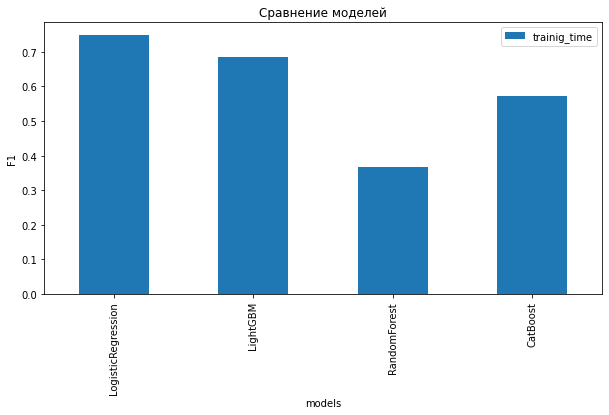

In [32]:
result_table['F1'].plot(kind='bar', legend=False, figsize=(10, 5))
plt.xlabel('models')
plt.ylabel('F1')
plt.legend(list(result_table))
plt.title('Сравнение моделей')
plt.show()

In [33]:
start = time.time()
predictions_cbr = grid_cbr.best_estimator_.predict(tf_idf_valid)
end = time.time()
pred_cbr_time = end-start
f1_cbr = f1_score(target_valid, predictions_cbr)
f1_cbr

0.7124920735573873

In [34]:
start = time.time()
predictions_lr = grid_lr.best_estimator_.predict(tf_idf_valid)
end = time.time()
pred_cbr_time = end-start 
f1_lr = f1_score(target_valid, predictions_lr)
f1_lr

0.7581291759465478

In [35]:
models_final = []
models_final.append([grid_cbr.refit_time_ , pred_cbr_time, f1_cbr])
models_final.append([grid_lr.refit_time_ , pred_lr_time, f1_lr])

In [36]:
table_final = pd.DataFrame(data=models_final, 
                            index=['CatBoost','LogisticRegression'], 
                            columns=['trainig_time', 'predict_time', 'rmse']
                           )
table_final

,trainig_time,predict_time,rmse
CatBoost,1803.409375,0.004069,0.712492
LogisticRegression,55.100216,0.003969,0.758129


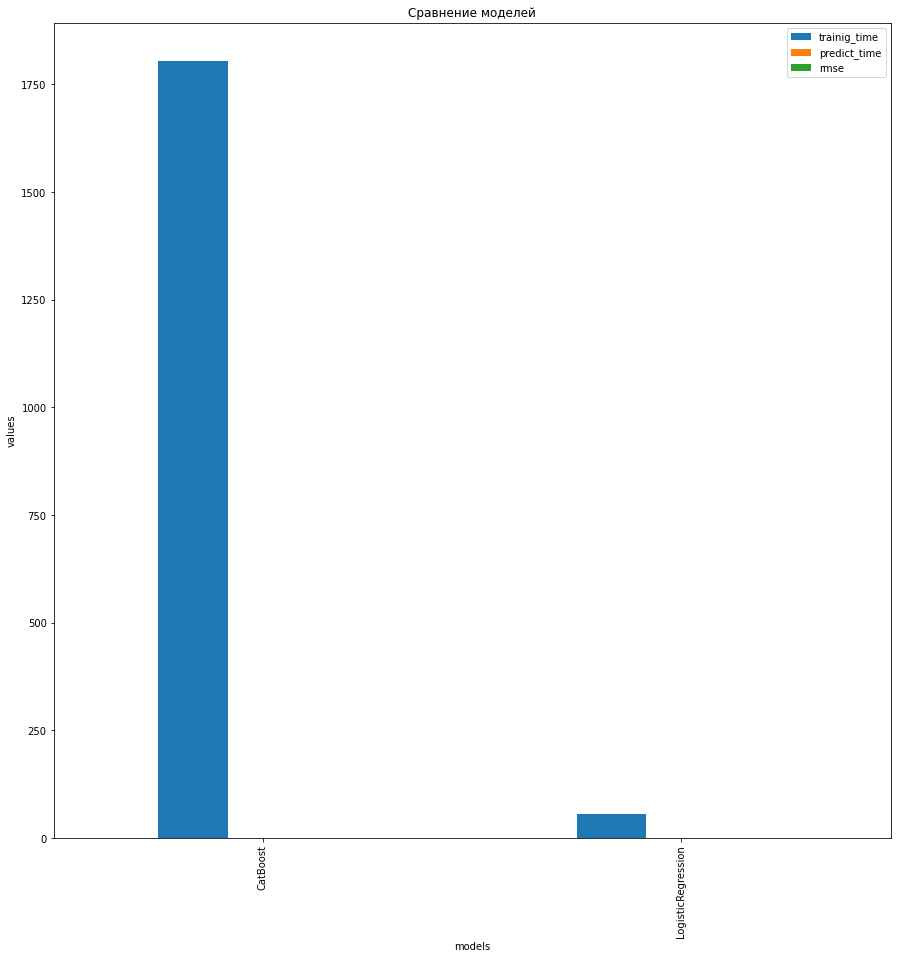

In [37]:
table_final.plot(kind='bar', legend=False, figsize=(15, 15))
plt.xlabel('models')
plt.ylabel('values')
plt.legend(list(table_final))
plt.title('Сравнение моделей')
plt.show()

In [38]:
predictions_lr = grid_lr.best_estimator_.predict(tf_idf_test)
f1_lr = f1_score(target_test, predictions_lr)
f1_lr

0.7589317507418398

- Обучил разные модели с разными гиперпараметрами
- Оценил их резкльтативность метрикой F1 
- Проанализировал время на обучение 

## Выводы

- Открыл и подготовил данные
- Обучил разные мадели 
- лучший результат по метрике F1 показала модель Logistic Regression